In [4]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Age補完⇒Title(名前の中にあるMrsなど)ごとに中央値で補完

#まずtitle抽出
train["title"] = train["Name"].str.extract("(A-Za-z+)\.",expand=False)

#titleごとの中央値でAge補完
title_age_map = train.groupby("title")["age"].median()

# 補完関数
def fill_age(row):
    if pd.isnull(row["Age"]):
        return title_age_map[row["Title"]]
    else:
        return row["Age"]

train["Age"] = train.apply(fill_age, axis=1)

KeyError: 'Column not found: age'

In [6]:
train["Title"] = train["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

# Titleごとの中央値で Age を補完
title_age_map = train.groupby("Title")["Age"].median()

# 補完関数
def fill_age(row):
    if pd.isnull(row["Age"]):
        return title_age_map[row["Title"]]
    else:
        return row["Age"]

train["Age"] = train.apply(fill_age, axis=1)

In [7]:
train["HasCabin"] = train["Cabin"].notnull().astype(int)

In [8]:
train["CabinLetter"] = train["Cabin"].str[0]

In [9]:
# 例：Sex
train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
# Embarked：欠損補完も先に！
train["Embarked"] = train["Embarked"].fillna("S")
embarked_map = {"S": 0, "C": 1, "Q": 2}
train["Embarked"] = train["Embarked"].map(embarked_map)

In [10]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
train["IsAlone"] = (train["FamilySize"] == 1).astype(int)

In [11]:
# レアな称号をまとめる
title_map = {
    "Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3,
    "Dr": 4, "Rev": 4, "Col": 4, "Major": 4,
    "Mlle": 1, "Ms": 1, "Mme": 2,
    "Lady": 4, "Countess": 4, "Sir": 4,
    "Jonkheer": 4, "Don": 4, "Dona": 4, "Capt": 4
}

train["Title"] = train["Title"].map(title_map).fillna(4).astype(int)

In [12]:
# testにもTitleを追加
test["Title"] = test["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
test["Title"] = test["Title"].map(title_map).fillna(4).astype(int)

In [13]:
print(train["Title"].value_counts())
print(test["Title"].value_counts())

Title
0    517
1    185
2    126
3     40
4     23
Name: count, dtype: int64
Title
0    240
1     79
2     72
3     21
4      6
Name: count, dtype: int64


In [14]:
# --- 欠損補完 ---
# Fareの欠損 → trainの中央値で埋める
test["Fare"] = test["Fare"].fillna(train["Fare"].median())

# Ageの欠損 → trainのTitleごとの中央値で補完
test["Age"] = test.apply(lambda row: title_age_map[row["Title"]] if pd.isnull(row["Age"]) else row["Age"], axis=1)

# Embarked 欠損（まれにある）を "S" で埋めて数値化
test["Embarked"] = test["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# Sex 変換
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

# FamilySize & IsAlone
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1
test["IsAlone"] = (test["FamilySize"] == 1).astype(int)

# Cabin → HasCabin フラグ作成
test["HasCabin"] = test["Cabin"].notnull().astype(int)


C:\Users\amnos\AppData\Local\Temp\ipykernel_7288\1792087513.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test["Age"] = test.apply(lambda row: title_age_map[row["Title"]] if pd.isnull(row["Age"]) else row["Age"], axis=1)


In [15]:
train.groupby("Sex")["Survived"].mean()

Sex
0    0.188908
1    0.742038
Name: Survived, dtype: float64

In [16]:
pd.cut() + groupby()

TypeError: cut() missing 2 required positional arguments: 'x' and 'bins'

In [17]:
groupby("Pclass")["Survived"].mean()

NameError: name 'groupby' is not defined

In [18]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [19]:
train.groupby("Title")["Survived"].mean()

Title
0    0.156673
1    0.702703
2    0.793651
3    0.575000
4    0.347826
Name: Survived, dtype: float64

In [20]:
train.groupby("Embarked")["Survived"].mean()

Embarked
0    0.339009
1    0.553571
2    0.389610
Name: Survived, dtype: float64

In [22]:
train.groupby("Embarked")["Survived"].mean()

Embarked
0    0.339009
1    0.553571
2    0.389610
Name: Survived, dtype: float64

C:\Users\amnos\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amnos\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amnos\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23384 (\N{CJK UNIFIED IDEOGRAPH-5B58}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amnos\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\amnos\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Use

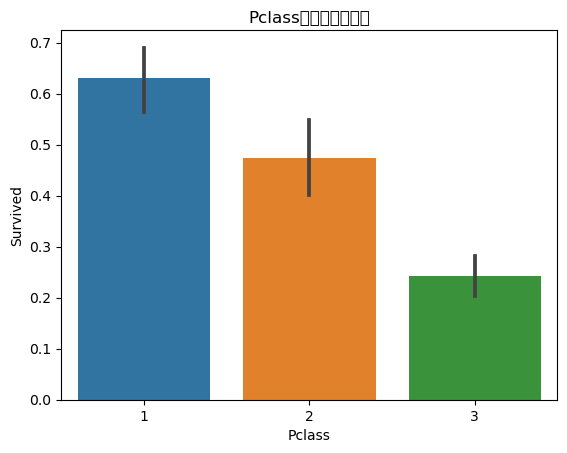

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=train, x="Pclass", y="Survived")
plt.title("Pclassと生存率の関係")
plt.show()

In [24]:
import pandas as pd

importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values(ascending=False).plot(kind="bar")
plt.title("特徴量の重要度")
plt.show()

NameError: name 'model' is not defined

In [25]:
features = [
    "Pclass",      # チケットクラス
    "Sex",         # 性別（0/1に変換済み）
    "Age",         # 年齢（Titleベースで補完済み）
    "SibSp",       # 同乗兄弟・配偶者の数
    "Parch",       # 同乗親・子供の数
    "Fare",        # チケット料金（testの欠損補完済み）
    "Embarked",    # 出港地（数値化済み）
    "Title",       # 称号（数値化済み）
    "FamilySize",  # 家族の人数（SibSp + Parch + 1）
    "IsAlone",     # 単独乗船かどうか（1 or 0）
    "HasCabin"     # キャビンの情報があるか
]


In [26]:
X = train[features]
y = train["Survived"]

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 検証用に予測
val_preds = model.predict(X_val)
print("検証用データでの精度:", accuracy_score(y_val, val_preds))

検証用データでの精度: 0.8379888268156425


In [29]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 1.9 MB/s eta 0:01:19
   ---------------------------------------- 0.1/150.0 MB 1.3 MB/s eta 0:01:56
   ---------------------------------------- 0.5/150.0 MB 4.4 MB/s eta 0:00:35
   ---------------------------------------- 0.6/150.0 MB 4.9 MB/s eta 0:00:31
   ---------------------------------------- 1.0/150.0 MB 4.9 MB/s eta 0:00:31
   ---------------------------------------- 1.3/150.0 MB 5.4 MB/s eta 0:00:28
   ---------------------------------------- 1.4/150.0 MB 4.8 MB/s eta 0:00:31
   ---------------------------------------- 1.7/150.0 MB 5.2 MB/s eta 0:00:29
   ---------------------------------------- 1.8/150.0 MB 4.7 MB/s eta 0:00:32
    --------------------------------------- 2.0/150.0 MB 5.0 MB/s eta 0:00:30
    --------------------------------------- 2.2/150.0 MB 5.0 MB/s eta 0:00:30
    --------------------------------------- 2.4/150.0 MB 4.8 MB/s eta 0

In [30]:
import xgboost as xgb

In [31]:
# モデル作成
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# 予測
val_preds = xgb_model.predict(X_val)
print("XGBoost 検証精度:", accuracy_score(y_val, val_preds))

XGBoost 検証精度: 0.8268156424581006


C:\Users\amnos\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [32]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

val_preds = log_model.predict(X_val)
print("LogisticRegression 検証精度:", accuracy_score(y_val, val_preds))

LogisticRegression 検証精度: 0.7877094972067039


In [33]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 660.6 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.5 MB 1.2 MB/s eta 0:00:02
   ----------------- ---------------------- 0.6/1.5 MB 4.4 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.5 MB 3.4 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.5 MB 5.3 MB/s eta 0:00:01
   ----------------------------------- ---- 1.3/1.5 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [35]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# モデル作成
lgb_model = lgb.LGBMClassifier(random_state=42)

# 学習
lgb_model.fit(X_train, y_train)

# 検証予測
val_preds = lgb_model.predict(X_val)
print("LightGBM 検証精度:", accuracy_score(y_val, val_preds))

TypeError: descriptor '__call__' for 'type' objects doesn't apply to a 'property' object